# VQG Problem

We want to maximize profits of the utility provider, by using EV batteries to shift the energy network load in a profitable way.

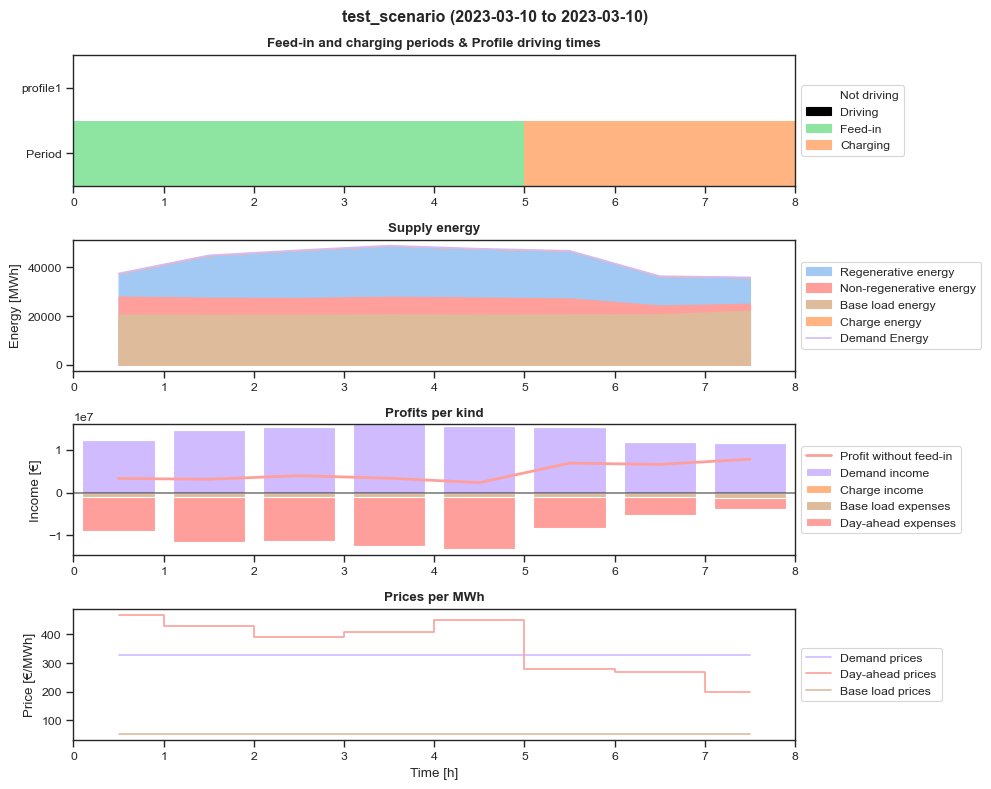

In [2]:
from vqg.visualization.visualization import plot_vqg_problem
from vqg.business.business_problem import VQGProblem
from vqg.data.load import load_vqg_problem_from_json

problem = load_vqg_problem_from_json("vqg.json")
plot_vqg_problem(problem)

## Now it is your turn!

We defined a VQG Problem. Now we want to find the prices, that maximizes the profit of the utility provider. Try to change the candidate array to get the best result.

In [19]:
from vqg.business.business_result import VQGResult
from vqg.visualization.visualization import plot_vqg_result

candidate = [100,100,100,0,0]
result = VQGResult(problem, variables=candidate, solution_time=1)
print(f"Total profit of utility provider: {result.get_profit():,.0f} €")
plot_vqg_result(result)

Total profit of utility provider: 38,458,330 €


## Solve the Vehicle-to-Grid Problem with OSQP

We use our VQG repository to solve the aforementioned problem. This solves the optimization program with our Qermit Framework.

> 2023-03-10 00:00:00 - 2023-03-10 08:00:00
Total profit of utility provider: 41,680,957 €


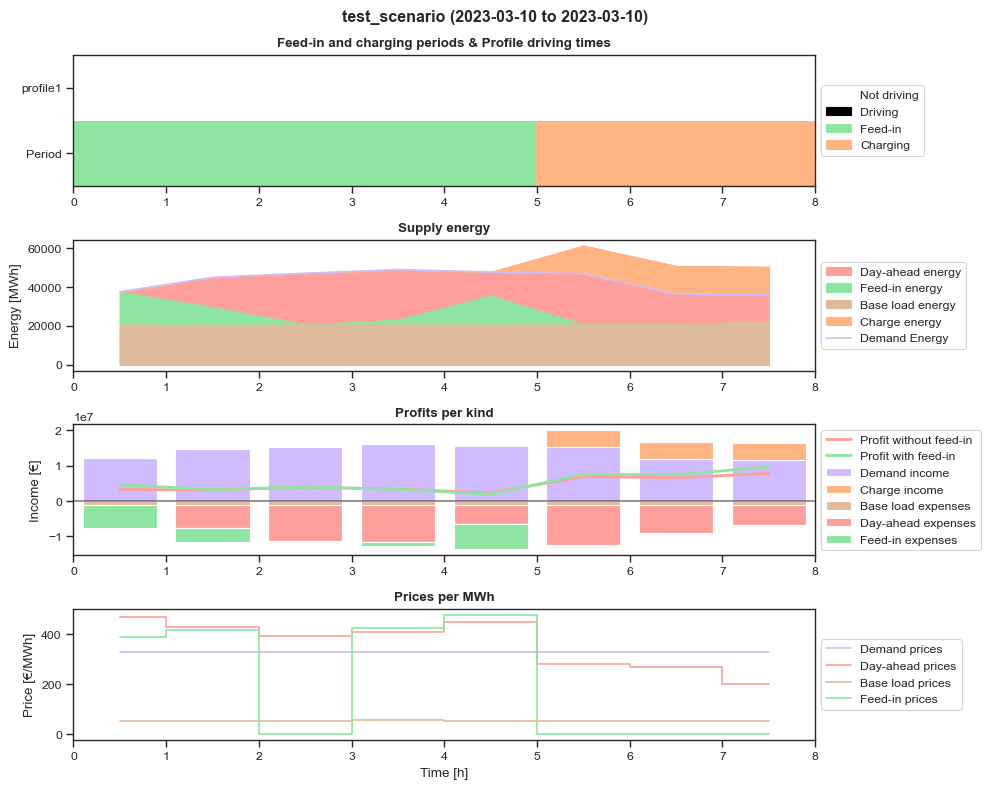

In [20]:
from vqg.business.business_problem import VQGProblem
from vqg.web.interface import solve_business_problem
from vqg.visualization.visualization import plot_vqg_result

result = solve_business_problem(problem)
print(f"Total profit of utility provider: {result.get_profit():,.0f} €")
plot_vqg_result(result)

# Additional Ressources

# Qermit - The Quantum Optimization Framework

Using Qermit to solve an optimization problem is really simple. Let's solve a Constrained Quadratic Program of the form
$$
\max_{x, y} \left(-x^2 - y^2 + 1.5x + 2y\right); \ 0.1 \le 0.3x + 0.1y \le 2.7; \ x,y \in [0, 2]
$$
Implement this in Qermit like this:

In [3]:
import numpy as np
from qermit.problems import CQP

quadratic = -np.diag(np.ones(2))
linear = np.array([1.5, 2.0])
constant = 0

constraints_lower = np.array([0.1])
constraints_upper = np.array([2.7])
linear_constraints = np.array([[0.3, 0.1]])

lower_bounds = np.array([0.0, 0.0])
upper_bounds = np.array([2.0, 2.0])

cqp = CQP(quadratic, linear, constant,
    linear_constraints, constraints_lower, constraints_upper,
    lower_bounds, upper_bounds,
    var_type="continuous", maximize=True
)

## Auto convert and solve problem on different hardware

Now, let's solve this problem on a classical QP solver like [OSQP](https://osqp.org/docs/interfaces/python.html#python-interface) and on a simulated Qiskit QAOA. We can also choose from various different classical, quantum and quantum-inspired algorithms.

In [5]:
from qermit.backend import QiskitBackend
from qermit.optimizer.osqp import OSQPOptimizer
from qermit.optimizer.pycma import PyCMAOptimizer
from qermit.optimizer.qiskit import QAOA
from qermit.run.job import JobFactory

# Load a local quantum simulator
backend = QiskitBackend().get_local_simulator_backend()
qaoa_optimizer = QAOA(backend)

osqp_optimizer = OSQPOptimizer()
cma_optimizer = PyCMAOptimizer()

jobs = JobFactory.create_jobs_autoconvert(cqp, [osqp_optimizer, qaoa_optimizer, cma_optimizer])

for job in jobs:
    job_result = job.run()
    print(job_result.optimizer_name)
    print(job_result)
    print("CQP value:", cqp.value(job_result.result))
    print()

OSQP
JobResult(result=array([0.75, 1.  ]), optimizer_time=4.41e-05, conversion_time=0.0, problem_name='CQP', optimizer_name='OSQP', converter_name='')
CQP value: 1.5624999999999998

Qiskit-QAOA
JobResult(result=array([0.96774194, 0.83870968]), optimizer_time=16.793366193771362, conversion_time=0.04500293731689453, problem_name='CQP', optimizer_name='Qiskit-QAOA', converter_name='CQP->QUBO')
CQP value: 1.489073881373569

PyCMA
JobResult(result=array([0.75000003, 0.99999997]), optimizer_time=0.08190798759460449, conversion_time=0.0, problem_name='CQP', optimizer_name='PyCMA', converter_name='CQP->CP')
CQP value: 1.5624999999999978

